In [1]:
import os
import os.path as path

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.python.tools import freeze_graph
from tensorflow.python.tools import optimize_for_inference_lib

In [2]:
MODEL_NAME = 'CIFAR10_Convnet'
Saved_Model_Path = "../checkpoints/"
tensorboard_log_path = "../tensorboard/"

# Input_node_names = "Input_data/Reshape"  '''For reference'''
# Output_node_name = "Output/Softmax"

output_size = 10

In [3]:
#todo: add the code for final softmax layer and return as output
class Model_CNN:
  
#We'll incorporate batch norm later

#def batch_norm(x):
#  return tf.nn.batch_normalization()  
  
  def __init__(self, x_in, y_in):
    self.n_class = 10
    self._create_architecture(x_in, y_in)
    
  def _create_architecture(self, x_in, y_in):
    self.prediction, self.out_prob = self._CNN_fw_pass(x_in)
    self.cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = self.prediction, labels = tf.argmax(y_in,1) ))
    self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.cost)
    
    
    correct = tf.equal(tf.argmax(self.prediction,1), tf.argmax(y_in,1))
    self.accuracy = tf.reduce_mean(tf.cast(correct,tf.float64))
 #   prediction = tf.cast(prediction,tf.float32)
 #   self.accuracy = tf.nn.in_top_k(prediction, y_in, 1)
    tf.summary.scalar("loss", self.cost)
    tf.summary.scalar("accuracy", self.accuracy)
    self.merged_summary = tf.summary.merge_all()
    
  
  def _CNN_fw_pass(self, input_data):
    
    weights = {  "conv1_weight": tf.Variable(tf.cast(tf.truncated_normal([3,3,3,32], stddev=0.08 ),dtype=tf.float32)),
                    "conv2_weight": tf.Variable(tf.cast(tf.truncated_normal([3,3,32,64], stddev=0.08 ),dtype=tf.float32)),
                    "conv3_weight": tf.Variable(tf.cast(tf.truncated_normal([3,3,64,128], stddev=0.08 ),dtype=tf.float32)),
                    "fc1_weight": tf.Variable(tf.cast(tf.truncated_normal([4*4*128,1024], stddev=0.08 ),dtype=tf.float32)),
                    "fc2_weight": tf.Variable(tf.cast(tf.truncated_normal([1024,128], stddev=0.08 ),dtype=tf.float32)),
                    "output_weight": tf.Variable(tf.cast(tf.truncated_normal([128,output_size], stddev=0.08 ),dtype=tf.float32))
                 }
    
    bias = {     "conv1_bias": tf.Variable(tf.cast(tf.zeros([32]),dtype=tf.float32)),
                "conv2_bias": tf.Variable(tf.cast(tf.zeros([64]),dtype=tf.float32)),
                "conv3_bias": tf.Variable(tf.cast(tf.zeros([128]),dtype=tf.float32)),
                "fc1_bias": tf.Variable(tf.cast(tf.zeros([1024]),dtype=tf.float32)),
                "fc2_bias": tf.Variable(tf.cast(tf.zeros([128]),dtype=tf.float32)),
                "output_bias": tf.Variable(tf.cast(tf.zeros([output_size]),dtype=tf.float32))
          }
       
    
    #  input_data = data.reshape()
    with tf.name_scope("Input_data"):
#       print("input_data.shape = "+str(input_data.shape))
      data_in = tf.reshape(input_data, [-1, 32,32,3])
#       print("data_in.shape = "+str(data_in.shape))
    
    with tf.name_scope("Convolution_1"):
      conv1 = self.conv_2d(data_in, weights["conv1_weight"])
  #    conv1 = tf.layers.BatchNormalization(conv1, axis=-1)
      conv1 = tf.add(conv1, bias["conv1_bias"])
      activated1 = self.activation(conv1, "relu")

    with tf.name_scope("MaxPool_1"):
      maxpool1 = self.maxpool_2d(activated1)

    with tf.name_scope("Convolution_2"):
      conv2 = self.conv_2d(maxpool1, weights["conv2_weight"])
  #    conv2 = tf.layers.BatchNormalization(conv2, axis=-1)
      conv2 = tf.add(conv2, bias["conv2_bias"])
      activated2 = self.activation(conv2, "relu")

    with tf.name_scope("MaxPool_2"):
      maxpool2 = self.maxpool_2d(activated2)

    with tf.name_scope("Convolution_3"):
      conv3 = self.conv_2d(maxpool2, weights["conv3_weight"])
  #    conv3 = tf.layers.BatchNormalization(conv3, axis=-1)
      conv3 = tf.add(conv3, bias["conv3_bias"])
      activated3 = self.activation(conv3, "relu")
      
    with tf.name_scope("MaxPool_3"):
      maxpool3 = self.maxpool_2d(activated3)

    with tf.name_scope("Fully_connected_1"):
      fc1 = tf.reshape(maxpool3, [-1, 4*4*128 ])
      fc1 = tf.add(tf.matmul(fc1, weights["fc1_weight"]),  bias["fc1_bias"])
      activated4 = self.activation(fc1, "relu")

    with tf.name_scope("Fully_connected_2"):
      fc2 = tf.add(tf.matmul(activated4, weights["fc2_weight"]),  bias["fc2_bias"])
      activated5 = self.activation(fc2, "relu")
     
    with tf.name_scope("Output"):
      out  = tf.add(tf.matmul(activated5, weights["output_weight"]),  bias["output_bias"])
      out_prob = tf.nn.softmax(out, axis = -1)
      out_class_pred = tf.argmax(out_prob, 1)

    return out, out_prob
  
  #helpers
  def conv_2d(self,x, w):
    return tf.nn.conv2d(x, w, padding="SAME",strides=[1,1,1,1])

  def maxpool_2d(self,x):
    return tf.nn.max_pool(x, [1,2,2,1], [1,2,2,1], padding = "SAME")

  def activation(self,x, activation_fn):
    if(activation_fn == "relu"):
      return tf.nn.relu(x)
    elif(activation_fn == "sigmoid"):
      return tf.nn.sigmoid(x)
    elif(activation_fn == "tanh"):
      return tf.nn.tanh(x)
    else:
      return tf.nn.sigmoid(x)

[7]


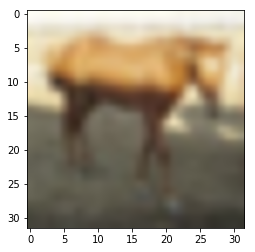

In [4]:
# Load and preprocess data here
(x_train,y_train),(x_test,y_test) =  tf.keras.datasets.cifar10.load_data()

# Uncomment following lines to visualize loaded data

# print("x_train.shape = "+str(x_train.shape))
# print("y_train.shape = "+str(y_train.shape))
# print("x_test.shape = "+str(x_test.shape))
# print("y_test.shape = "+str(y_test.shape))

index = 2000

plt.imshow(x_train[index], interpolation = "gaussian")
print(str(y_train[index]))

#normalize and prep loaded dataset

# normalizing x 0-255 pixel values
# converting y to one hot vectors/matrices

x_train_flatten = x_train/255
x_test_flatten = x_test/255
tf.cast(x_train_flatten, tf.float32)
tf.cast(x_test_flatten, tf.float32)
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10)

rmean,gmean,bmean = np.mean(x_train_flatten[:,:,:,0]),  np.mean(x_train_flatten[:,:,:,1]),  np.mean(x_train_flatten[:,:,:,2])
rstd, gstd, bstd = np.std(x_train_flatten[:,:,:,0]), np.std(x_train_flatten[:,:,:,1]), np.std(x_train_flatten[:,:,:,2])

mean = {"rmean":rmean,"gmean":gmean,"bmean":bmean}
stdev = {"rstd":rstd, "gstd":gstd, "bstd":bstd}   

x_train_norm = x_train_flatten
x_test_norm = x_test_flatten

x_train_norm[:,:,:,0] -= mean["rmean"]
x_train_norm[:,:,:,1] -= mean["gmean"]
x_train_norm[:,:,:,2] -= mean["bmean"]

x_train_norm[:,:,:,0] /= stdev["rstd"]
x_train_norm[:,:,:,1] /= stdev["gstd"]
x_train_norm[:,:,:,2] /= stdev["bstd"]

In [8]:
def train_and_save_model():

  tf.reset_default_graph()

  x = tf.placeholder(tf.float32, shape=[None, 32,32,3], name = "x")
  y = tf.placeholder(tf.float32, shape=[None, 10], name = "y")

#  Place hyperparams here

  output_size = 10
  batch_size = 256
  num_epochs = 20
  
  writer = tf.summary.FileWriter(tensorboard_log_path)


  dataset = tf.data.Dataset.from_tensor_slices((x, y)) 
  dataset = dataset.batch(batch_size)
  iterator = dataset.make_initializable_iterator()


  data_x, data_y = iterator.get_next()
  model = Model_CNN(data_x, data_y)

  with tf.Session() as sess:


    sess.run(tf.global_variables_initializer())
    
    saver = tf.train.Saver(tf.global_variables())
    
    writer.add_graph(sess.graph)

    tf.train.write_graph(sess.graph_def, Saved_Model_Path, MODEL_NAME + '.pbtxt', True)
      
    
    train_count = 0
    for epoch_no in range(num_epochs):
      train_loss, train_accuracy = 0, 0
      test_loss, test_accuracy = 0, 0

      sess.run(iterator.initializer, feed_dict = {x: x_train_norm, y: y_train_categorical})

      try:
          while True:

            pred,_, loss, acc, summary = sess.run([model.prediction, model.optimizer, model.cost, model.accuracy, model.merged_summary])
            # print(pred)
            train_count+=1
            train_loss +=loss
            train_accuracy += acc

            if train_count % 5 == 0:
              writer.add_summary(summary, train_count)

      except tf.errors.OutOfRangeError:
        pass

      print('\nEpoch No: {}'.format(epoch_no + 1))
      print('Train accuracy = {:.4f}, loss = {:.4f}'.format((train_accuracy / (len(y_train_categorical)/batch_size)), train_loss / (len(y_train_categorical)/batch_size)))
    saver.save(sess, Saved_Model_Path+MODEL_NAME+".chkp")

In [9]:
def export_model(input_node_names, output_node_name):
  
  # freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
  #                           input_binary, checkpoint_path, output_node_names,
  #                           restore_op_name, filename_tensor_name,
  #                           output_frozen_graph_name, clear_devices, "")
  
  freeze_graph.freeze_graph(Saved_Model_Path+MODEL_NAME+".pbtxt", None, False, Saved_Model_Path+MODEL_NAME+".chkp", output_node_name, "save/restore_all", "save/Const:0",
                            Saved_Model_Path+"frozen_"+MODEL_NAME+".pb", True, "" )

In [10]:
train_and_save_model()



Epoch No: 1
Train accuracy = 0.4808, loss = 1.4728

Epoch No: 2
Train accuracy = 0.6551, loss = 0.9946

Epoch No: 3
Train accuracy = 0.7228, loss = 0.8053

Epoch No: 4
Train accuracy = 0.7698, loss = 0.6721

Epoch No: 5
Train accuracy = 0.8103, loss = 0.5579

Epoch No: 6
Train accuracy = 0.8405, loss = 0.4677

Epoch No: 7
Train accuracy = 0.8658, loss = 0.3947

Epoch No: 8
Train accuracy = 0.8873, loss = 0.3323

Epoch No: 9
Train accuracy = 0.9119, loss = 0.2596

Epoch No: 10
Train accuracy = 0.9308, loss = 0.2069

Epoch No: 11
Train accuracy = 0.9423, loss = 0.1757

Epoch No: 12
Train accuracy = 0.9574, loss = 0.1324

Epoch No: 13
Train accuracy = 0.9685, loss = 0.1033

Epoch No: 14
Train accuracy = 0.9808, loss = 0.0703

Epoch No: 15
Train accuracy = 0.9868, loss = 0.0503

Epoch No: 16
Train accuracy = 0.9892, loss = 0.0440

Epoch No: 17
Train accuracy = 0.9913, loss = 0.0367

Epoch No: 18
Train accuracy = 0.9922, loss = 0.0340

Epoch No: 19
Train accuracy = 0.9912, loss = 0.0372

E

In [24]:
export_model("x", "Output/Softmax")

INFO:tensorflow:Restoring parameters from ./checkpoints/CIFAR10_Convnet.chkp
INFO:tensorflow:Froze 12 variables.
Converted 12 variables to const ops.


AttributeError: module 'tensorflow' has no attribute 'Graphdef'

In [22]:
!IMAGE_SIZE=32
tflite_convert \
  --graph_def_file=/home/bindusar/Documents/Notebooks/CIFAR/prod/src/checkpoints/frozen_CIFAR10_Convnet.pb \
  --output_file=/home/bindusar/Documents/Notebooks/CIFAR/prod/src/output/CIFAR10_Convnet.tflite \
  --input_format=TENSORFLOW_GRAPHDEF \
  --output_format=TFLITE \
  --input_shape=1,${IMAGE_SIZE},${IMAGE_SIZE},3 \
  --input_array=Input_data/Reshape \
  --output_array=Output/Softmax \
  --inference_type=FLOAT \
  --input_data_type=FLOAT

SyntaxError: invalid syntax (<ipython-input-22-40dd8d4ce487>, line 3)

In [23]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name="")

    return graph
    
graph = load_graph('/home/bindusar/Documents/Notebooks/CIFAR/prod/src/checkpoints/frozen_CIFAR10_Convnet.pb')

for op in graph.get_operations():
    print(op.name)

Iterator
IteratorGetNext
Variable
Variable/read
Variable_1
Variable_1/read
Variable_2
Variable_2/read
Variable_3
Variable_3/read
Variable_4
Variable_4/read
Variable_5
Variable_5/read
Variable_6
Variable_6/read
Variable_7
Variable_7/read
Variable_8
Variable_8/read
Variable_9
Variable_9/read
Variable_10
Variable_10/read
Variable_11
Variable_11/read
Input_data/Reshape/shape
Input_data/Reshape
Convolution_1/Conv2D
Convolution_1/Add
Convolution_1/Relu
MaxPool_1/MaxPool
Convolution_2/Conv2D
Convolution_2/Add
Convolution_2/Relu
MaxPool_2/MaxPool
Convolution_3/Conv2D
Convolution_3/Add
Convolution_3/Relu
MaxPool_3/MaxPool
Fully_connected_1/Reshape/shape
Fully_connected_1/Reshape
Fully_connected_1/MatMul
Fully_connected_1/Add
Fully_connected_1/Relu
Fully_connected_2/MatMul
Fully_connected_2/Add
Fully_connected_2/Relu
Output/MatMul
Output/Add
Output/Softmax
